# Importación de paquetes iniciales

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import logging
import os
from datetime import datetime, timedelta
from google.cloud import bigquery
import google.auth
from google.oauth2 import service_account
from google.cloud.bigquery.schema import SchemaField
from google.cloud.bigquery.table import Table

# Configuración del sistema de excepciones y logs
Se van a almacenar en una carpeta en el root según las indicaciones de la prueba

In [10]:
# Crear un directorio de registros si no existe
log_dir="logs"
os.makedirs(log_dir, exist_ok=True)

# Configurar la configuración de registro
log_file=os.path.join(log_dir, "application.log")
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
file_handler=logging.FileHandler(log_file)
file_handler.setLevel(logging.ERROR)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(file_handler)

In [11]:
# Define la ruta del archivo
ruta_archivo="datasets/flights.csv"

# Lee el archivo CSV en un DataFrame de pandas
df=pd.read_csv(ruta_archivo, delimiter="|")

# Muestra las primeras filas del DataFrame
df.head()

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,...,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE
0,54548800,20020101,WN,Southwest Airlines Co.: WN,N103@@,1425,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1648.0,4.0,1655,1652.0,-3.0,90.0,87.0,F,False,580 miles
1,55872300,20020101,CO,Continental Air Lines Inc.: CO,N83872,150,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1419.0,16.0,1426,1435.0,9.0,116.0,119.0,False,F,744 miles
2,54388800,20020101,WN,Southwest Airlines Co.: WN,N334@@,249,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1618.0,2.0,1500,1620.0,80.0,105.0,102.0,F,False,718 miles
3,54486500,20020101,WN,Southwest Airlines Co.: WN,N699@@,902,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1947.0,1.0,1950,1948.0,-2.0,85.0,83.0,0,0,487 miles
4,55878700,20020103,CO,Continental Air Lines Inc.: CO,N58606,234,ABQ,AlbuquerqueNM: Albuquerque International Sunport,Albuquerque,NM,...,1742.0,5.0,1750,1747.0,-3.0,115.0,114.0,F,False,744 miles


In [12]:
df.shape

(1191805, 31)

Se comprueba que el dataset tiene más de un millon de filas como se pide en la prueba y que carga todas las filas del csv

# EDA

In [13]:
# Se revisa el tipo de cada columna para identificar si están correctas o se debe hacer algun ajuste
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TRANSACTIONID      1191805 non-null  int64  
 1   FLIGHTDATE         1191805 non-null  int64  
 2   AIRLINECODE        1191805 non-null  object 
 3   AIRLINENAME        1191805 non-null  object 
 4   TAILNUM            1034988 non-null  object 
 5   FLIGHTNUM          1191805 non-null  int64  
 6   ORIGINAIRPORTCODE  1191805 non-null  object 
 7   ORIGAIRPORTNAME    1191805 non-null  object 
 8   ORIGINCITYNAME     1191805 non-null  object 
 9   ORIGINSTATE        1180963 non-null  object 
 10  ORIGINSTATENAME    1180963 non-null  object 
 11  DESTAIRPORTCODE    1191805 non-null  object 
 12  DESTAIRPORTNAME    1191805 non-null  object 
 13  DESTCITYNAME       1191805 non-null  object 
 14  DESTSTATE          1180967 non-null  object 
 15  DESTSTATENAME      1180967 non-n

Se identifica que la columna FlightDate deberia ser una fecha, la distancia debería ser un número, Cancelled y Diverted deben tener valor booleano

In [14]:
try:
    #Se convierte la fecha
    df['FLIGHTDATE']=pd.to_datetime(df['FLIGHTDATE'], format='%Y%m%d')

    #Se ajusta la columna Distance
    df['DISTANCE']=df['DISTANCE'].str.replace(' miles', '')
    df['DISTANCE']=pd.to_numeric(df['DISTANCE'],errors='raise')

    #Se ajustan las columnas booleanas
    df['CANCELLED']=df['CANCELLED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})
    df['DIVERTED']=df['DIVERTED'].map({'0': False, '1': True, 'True': True, 'False': False, 'T': True, 'F': False})

    # Convertir columnas a formato hora
    columnas_hora = ['CRSDEPTIME', 'DEPTIME', 'WHEELSOFF', 'WHEELSON', 'CRSARRTIME', 'ARRTIME']

    for columna in columnas_hora:
        df[columna] = pd.to_datetime(df[columna],errors='coerce', format='%H%M').dt.time

except Exception as e:
    logging.exception(f"Se ha presentado una excepcion: {e}")

Aunque no es del todo necesario capturas los errores en este punto pues es muy manual este proceso se deja para probar el sistema logging, si se corre dos veces este bloque se dispara una excepcion por aplicarle .str. a la columna distance que ya es numerica

In [15]:
# Se verifican los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   TRANSACTIONID      1191805 non-null  int64         
 1   FLIGHTDATE         1191805 non-null  datetime64[ns]
 2   AIRLINECODE        1191805 non-null  object        
 3   AIRLINENAME        1191805 non-null  object        
 4   TAILNUM            1034988 non-null  object        
 5   FLIGHTNUM          1191805 non-null  int64         
 6   ORIGINAIRPORTCODE  1191805 non-null  object        
 7   ORIGAIRPORTNAME    1191805 non-null  object        
 8   ORIGINCITYNAME     1191805 non-null  object        
 9   ORIGINSTATE        1180963 non-null  object        
 10  ORIGINSTATENAME    1180963 non-null  object        
 11  DESTAIRPORTCODE    1191805 non-null  object        
 12  DESTAIRPORTNAME    1191805 non-null  object        
 13  DESTCITYNAME       1191805 

In [8]:
# Análisis de valores nulos
null_values=df.isnull().sum() / len(df) * 100
print("Porcentaje de valores nulos por columna:")
print(null_values)

Porcentaje de valores nulos por columna:
TRANSACTIONID         0.000000
FLIGHTDATE            0.000000
AIRLINECODE           0.000000
AIRLINENAME           0.000000
TAILNUM              13.157941
FLIGHTNUM             0.000000
ORIGINAIRPORTCODE     0.000000
ORIGAIRPORTNAME       0.000000
ORIGINCITYNAME        0.000000
ORIGINSTATE           0.909713
ORIGINSTATENAME       0.909713
DESTAIRPORTCODE       0.000000
DESTAIRPORTNAME       0.000000
DESTCITYNAME          0.000000
DESTSTATE             0.909377
DESTSTATENAME         0.909377
CRSDEPTIME            0.701625
DEPTIME               2.432445
DEPDELAY              2.377486
TAXIOUT              15.100792
WHEELSOFF            15.188978
WHEELSON             15.456807
TAXIIN               15.227743
CRSARRTIME            0.845776
ARRTIME               2.837629
ARRDELAY              2.622912
CRSELAPSEDTIME        0.035408
ACTUALELAPSEDTIME     2.622912
CANCELLED             0.000000
DIVERTED              0.000000
DISTANCE              0.00000

El porcentaje de datos faltantes en algunos campos va desde 0.9% hasta 15% en otros, en este punto del proceso no se considera eliminar estos registros, se procede a explorar los datos con el fin de decidir si descartar las columnas con alto porcentaje o si utilizar alguna técnica para completar la información faltante

C:\Users\alejo\AppData\Local\Temp\ipykernel_18724\3462987559.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


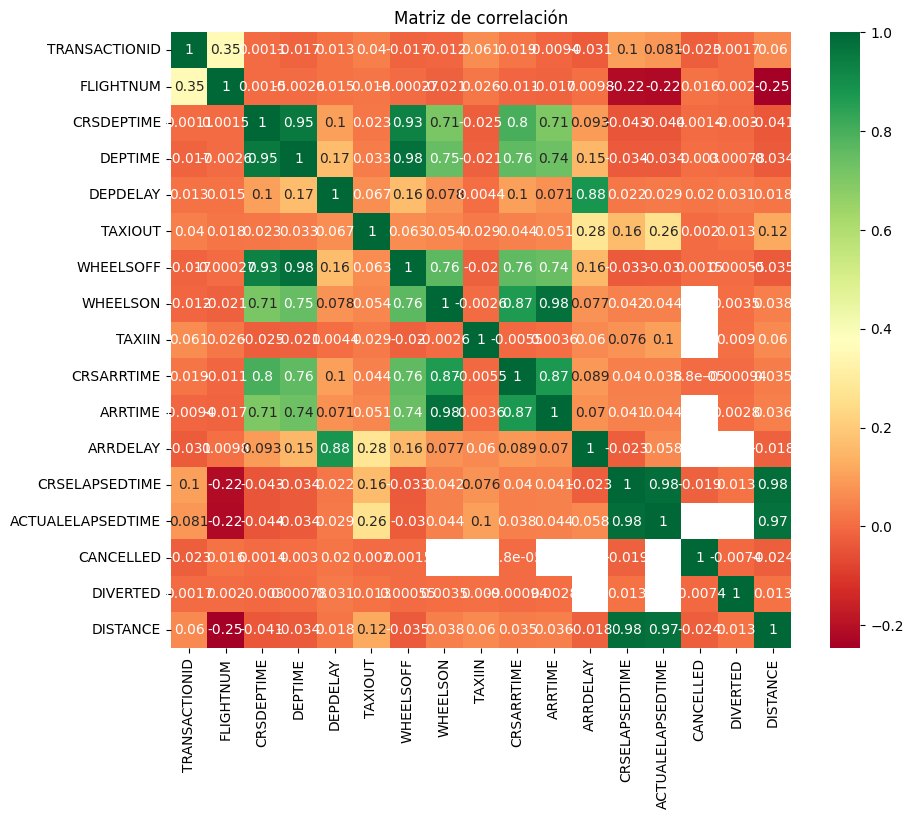

In [25]:
# Matriz de correlación
correlation_matrix=df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")
plt.title("Matriz de correlación")
plt.show()

Aunque la matriz de correlación se utiliza más para modelos numéricos y preparar la data para modelos predictivos en este punto nos puede dar una pista si al descartar una columna podríamos afectar otra

In [26]:
# Se identifican las columnas numéricas para buscar los posibles valores atípicos
columnas_numericas=df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Columnas numéricas:")
print(columnas_numericas)

Columnas numéricas:
['TRANSACTIONID', 'FLIGHTNUM', 'CRSDEPTIME', 'DEPTIME', 'DEPDELAY', 'TAXIOUT', 'WHEELSOFF', 'WHEELSON', 'TAXIIN', 'CRSARRTIME', 'ARRTIME', 'ARRDELAY', 'CRSELAPSEDTIME', 'ACTUALELAPSEDTIME', 'DISTANCE']


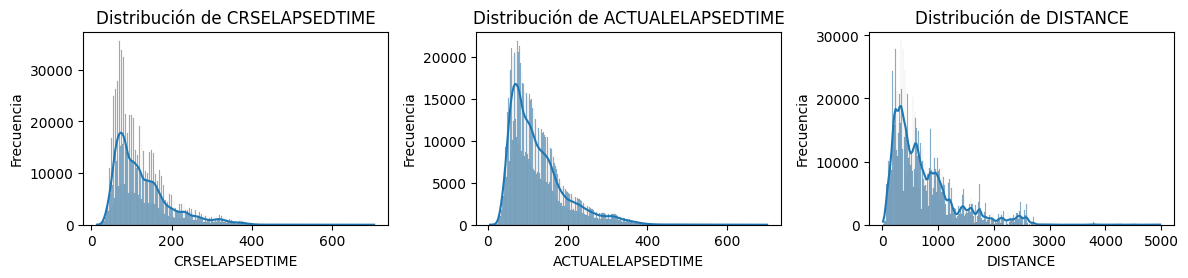

In [27]:
# Gráficas de distribución de columnas numéricas
plt.figure(figsize=(12, 10))
for i, columna in enumerate([ 'CRSELAPSEDTIME', 'ACTUALELAPSEDTIME', 'DISTANCE'], 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=columna, kde=True)
    plt.title(f"Distribución de {columna}")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [28]:
# Análisis de valores atípicos
# Se remueven dos columnas que son numericas pero como son ID no es necesario buscar valores atipicos
columnas_numericas.remove('TRANSACTIONID')
columnas_numericas.remove('FLIGHTNUM')
atipicos=pd.DataFrame(columns=["Columna", "Valor atípico"])

# Para identificar los valores atipicos se utiliza el método del rango intercuartil, si conocieramos mejor el contexto
# se podría escoger otro método como la media movil u otro método
for columna in columnas_numericas:
    q1=df[columna].quantile(0.25)
    q3=df[columna].quantile(0.75)
    iqr=q3 - q1
    limite_inferior=q1 - 1.5 * iqr
    limite_superior=q3 + 1.5 * iqr

    columna_atipica=df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    atipicos=pd.concat([atipicos,columna_atipica[[columna]]])

# Se eliminan los valores atípicos
df= df[~df.index.isin(atipicos.index)]

print("Valores atípicos:")
print(atipicos)

Valores atípicos:
        Columna Valor atípico  CRSDEPTIME  DEPTIME  DEPDELAY  TAXIOUT  \
2           NaN           NaN         NaN      NaN      83.0      NaN   
5           NaN           NaN         NaN      NaN      27.0      NaN   
6           NaN           NaN         NaN      NaN     167.0      NaN   
7           NaN           NaN         NaN      NaN     105.0      NaN   
8           NaN           NaN         NaN      NaN      60.0      NaN   
...         ...           ...         ...      ...       ...      ...   
1191664     NaN           NaN         NaN      NaN       NaN      NaN   
1191694     NaN           NaN         NaN      NaN       NaN      NaN   
1191733     NaN           NaN         NaN      NaN       NaN      NaN   
1191760     NaN           NaN         NaN      NaN       NaN      NaN   
1191789     NaN           NaN         NaN      NaN       NaN      NaN   

         WHEELSOFF  WHEELSON  TAXIIN  CRSARRTIME  ARRTIME  ARRDELAY  \
2              NaN       NaN     N

Vamos a verificar que efectivamente los datos ya tienen una mejor distribución pero como se aclaró anteriormente esto se hace con fines demostrativos, en un caso real se debería tener el contexto de la información para entender estos valores atípicos

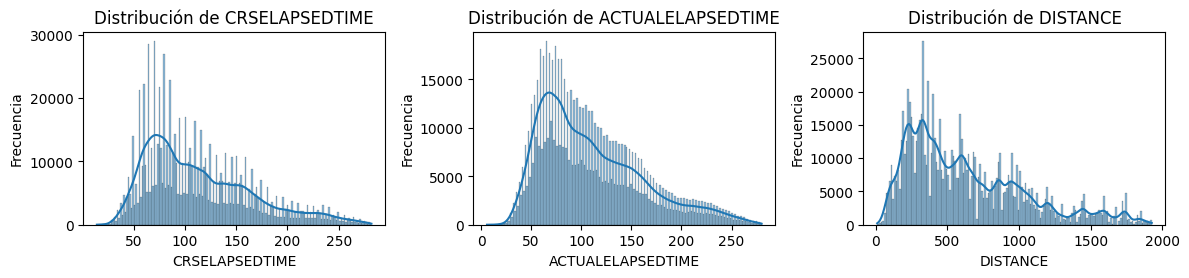

In [29]:
# Gráficas de distribución de columnas numéricas
plt.figure(figsize=(12, 10))
for i, columna in enumerate([ 'CRSELAPSEDTIME', 'ACTUALELAPSEDTIME', 'DISTANCE'], 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=columna, kde=True)
    plt.title(f"Distribución de {columna}")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()